In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.mnist import load_data

In [2]:
(train_x, train_y), (test_x, test_y) = load_data()
train_x = train_x.astype('float') / 127.5 - 1.
test_x  = test_x.astype('float')  / 127.5 - 1.
print(f'Train {train_x.shape} {train_y.shape}')
print(f'Test {test_x.shape} {test_y.shape}')

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


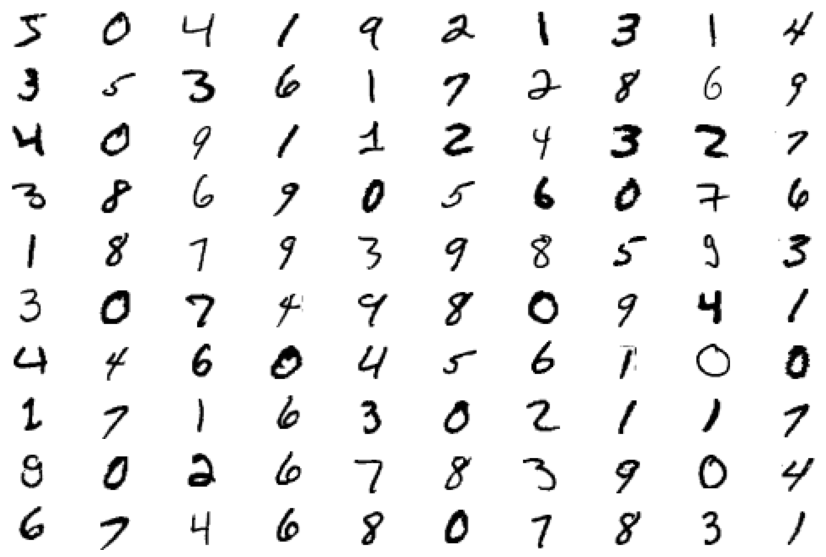

In [155]:
plt.figure(figsize=(15,10))
display_row = 10
for i in range(display_row**2):
    plt.subplot(display_row,display_row ,1+i)
    plt.axis('off')
    plt.imshow(train_x[i], cmap='gray_r')
plt.show()

First try a classification task.

In [134]:
discriminator = torch.nn.Sequential(
    torch.nn.Conv2d(1,64,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Conv2d(64,16,(3,3)),
    torch.nn.ReLU(), 
    torch.nn.MaxPool2d((2,2),stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(400,1000),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(1000,10),
    torch.nn.Sigmoid()
)

loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(discriminator.parameters())

In [135]:
from tqdm import tqdm 
epochs = 1
batch_size = 80
losses = []
# only 1 epoch is enough, no need to waste a lot of time
for epoch in range(epochs):
    shuffle = np.arange(train_y.size)
    np.random.shuffle(shuffle)

    for batch in tqdm(range(0, train_y.size, batch_size)):
        batch_x = train_x[shuffle[batch: batch+batch_size]].reshape((batch_size, 1, 28, 28))
        batch_y = train_y[shuffle[batch: batch+batch_size]]

        batch_x = torch.Tensor(batch_x)
        batch_y = torch.Tensor(batch_y).long()

        predict = discriminator(batch_x)
        loss = loss_f(predict, batch_y) 
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 750/750 [00:41<00:00, 17.96it/s]


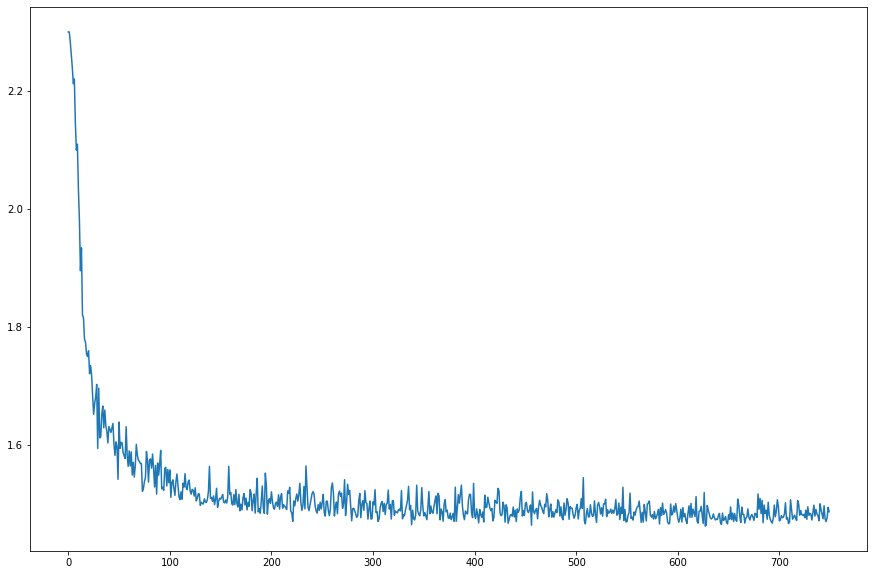

In [136]:
plt.figure(figsize=(15,10))
plt.plot(losses)

In [137]:
def validate(model, t_x, t_y, batch_size=80):
    acc = 0

    for batch in range(0, t_y.size, batch_size):
        batch_x = t_x[batch: batch+batch_size].reshape((batch_size, 1, 28, 28))
        batch_y = t_y[batch: batch+batch_size]

        batch_x = torch.Tensor(batch_x)
        batch_y = torch.Tensor(batch_y).long()

        with torch.no_grad():
            predict = model(batch_x).detach().numpy()
        predict = np.argmax(predict, axis=-1) - t_y[batch: batch+batch_size]
        predict = np.where(predict == 0, 1, 0)
        acc += np.sum(predict)

    return acc / t_y.size

acc1 = validate(discriminator, train_x, train_y)
acc2 = validate(discriminator, test_x , test_y )
print(f'Accuracy on train dataset = {acc1*100}%')
print(f'Accuracy on test dataset  = {acc2*100}%')

Accuracy on train dataset = 97.925%
Accuracy on test dataset  = 98.0%


Now we dive in the DCGAN part.

First we begin with random fake images generator ($28\times 28$ random pixels).

In [3]:
def generate_samples(n = 80):  # n < train_y.shape
    return train_x[np.random.randint(0, train_y.shape, size=(n,))]

def generate_samples_fake(n = 80):
    return np.random.randn(n, 28, 28)

In [122]:
discriminator = torch.nn.Sequential(
    torch.nn.Conv2d(1,6,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Conv2d(6,6,(3,3)),
    torch.nn.ReLU(), 
    torch.nn.MaxPool2d((2,2),stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(150,500),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(500,2),
    torch.nn.Softmax(dim=-1)
)

optimizer = torch.optim.Adam(discriminator.parameters())

In [123]:
from tqdm import tqdm 
epochs = 60
batch_size = 80
accs = []
for epoch in tqdm(range(epochs)):
    samples_real = generate_samples(batch_size // 2).reshape(batch_size//2, 1, 28, 28)
    samples_fake = generate_samples_fake(batch_size // 2).reshape(batch_size//2, 1, 28, 28)
    samples_real = torch.Tensor(samples_real)
    samples_fake = torch.Tensor(samples_fake)

    predicts_real = discriminator(samples_real)
    predicts_fake = discriminator(samples_fake)

    # no need logarithm here (by experience)
    loss  = torch.sum(predicts_real[:,0]) # the prob of real images predicted to be fake
    loss += torch.sum(predicts_fake[:,1]) # the prob of fake images predicted to be real
    loss *= (1. / batch_size)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = np.sum(np.argmax(predicts_real.detach().numpy(), axis=-1))
    acc += batch_size // 2 - np.sum(np.argmax(predicts_fake.detach().numpy(), axis=-1))
    accs.append(acc / batch_size)

100%|██████████| 60/60 [00:00<00:00, 70.05it/s]


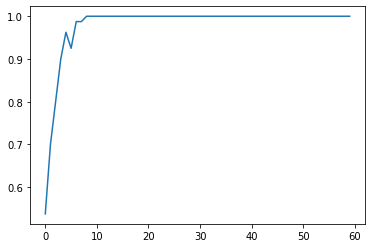

In [124]:
plt.plot(accs)
plt.show()

Around $20$ epochs can the discriminator tell apart the real and fake images with $100\%$ accuracy. This implies that real images indeed have some hidden commonalities.

Some possibly insightful links are listed below if one has problem with the training process or the network architecture.

https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

https://github.com/soumith/ganhacks/issues/14

https://ai.stackexchange.com/questions/9990/mismatch-between-the-definition-of-the-gan-loss-function-in-two-papers

This is a relatively small network compared to the one presented in the book. Be patient if the model seemingly makes no (or reversed) progress in the first 300 epochs.

In [137]:
latent_dim = 50

discriminator = torch.nn.Sequential(
    torch.nn.Conv2d(1,64,(3,3),stride=(2,2)),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Conv2d(64,64,(3,3),stride=(2,2)),
    torch.nn.LeakyReLU(), 
    torch.nn.Dropout(0.5),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
    torch.nn.Softmax(dim=-1)
)

generator = torch.nn.Sequential(
    torch.nn.Linear(latent_dim, 3136),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Unflatten(1, (64, 7, 7)),
    torch.nn.ConvTranspose2d(64, 32, (4,4), stride=2),
    torch.nn.LeakyReLU(0.2),    
    torch.nn.ConvTranspose2d(32, 32, (4,4), stride=2),
    torch.nn.LeakyReLU(0.2),    
    torch.nn.Conv2d(32, 1, (7,7)),
    torch.nn.Sigmoid()   # use sigmoid to generate pixels in [0,1]
)

optimizer_dis = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5,0.999))
optimizer_gen = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5,0.999))
losses_gan = []
losses_dis = []

In [128]:
# check that our generator outputs correct size
latent_seeds = torch.Tensor(np.random.randn(2,latent_dim))
print(generator(latent_seeds).shape)

torch.Size([2, 1, 28, 28])


In [163]:
from tqdm import tqdm 
epochs = 15000    # thousands of epochs might be sufficient

batch_size = 128
for epoch in tqdm(range(1+len(losses_gan), 1+len(losses_gan)+epochs)):
    # Discriminator part
    samples_real = generate_samples(batch_size // 2).reshape((batch_size // 2, 1, 28, 28))
    samples_real *= 0.5    # map all pixels into [0,1]
    samples_real += 0.5    # map all pixels into [0,1]
    samples_real = torch.Tensor(samples_real)
    predicts_real = discriminator(samples_real)

    latent_seeds = np.random.randn(batch_size // 2, latent_dim)
    latent_seeds = torch.Tensor(latent_seeds)
    samples_fake = generator(latent_seeds)
    predicts_fake = discriminator(samples_fake)

    loss  = torch.sum(torch.log(predicts_real[:,1]))  # the prob of real images predicted to be real
    loss += torch.sum(torch.log(predicts_fake[:,0]))  # the prob of fake images predicted to be fake
    loss *= (-1. / batch_size)
    losses_dis.append(loss.item())

    optimizer_dis.zero_grad()
    loss.backward()
    optimizer_dis.step()

    
    # Generator part
    latent_seeds = np.random.randn(batch_size // 2, latent_dim)
    latent_seeds = torch.Tensor(latent_seeds)
    samples_fake = generator(latent_seeds)
    predicts_fake = discriminator(samples_fake)

    loss = torch.sum(torch.log(predicts_fake[:,1]))  # the prob of fake images predicted to be real
    loss *= (-1. / batch_size)
    losses_gan.append(loss.item())

    optimizer_gen.zero_grad()
    loss.backward()
    optimizer_gen.step()

    if epoch % 1000 == 0: # save a version
        torch.save(generator.state_dict()    , f'DCGAN Models\\Generator {epoch}.pth')
        torch.save(discriminator.state_dict(), f'DCGAN Models\\Discriminator {epoch}.pth')
        np.savetxt(f'DCGAN Models\\loss.txt', np.array([losses_gan, losses_dis]))

100%|██████████| 6000/6000 [43:01<00:00,  2.32it/s]


In [204]:
# This is a template to load the models and the loss, 
# be careful to execute
'''
epoch = 15000
losses_gan = np.loadtxt(f'DCGAN Models\\loss.txt')[0]
losses_dis = np.loadtxt(f'DCGAN Models\\loss.txt')[1]
generator.load_state_dict(torch.load(f'DCGAN Models\\Generator {epoch}.pth'))
discriminator.load_state_dict(torch.load(f'DCGAN Models\\Discriminator {epoch}.pth'))
'''

<All keys matched successfully>

As plotted in the figure, the losses of the generator and discriminator are unstable in the beginning (before around 250 epochs).

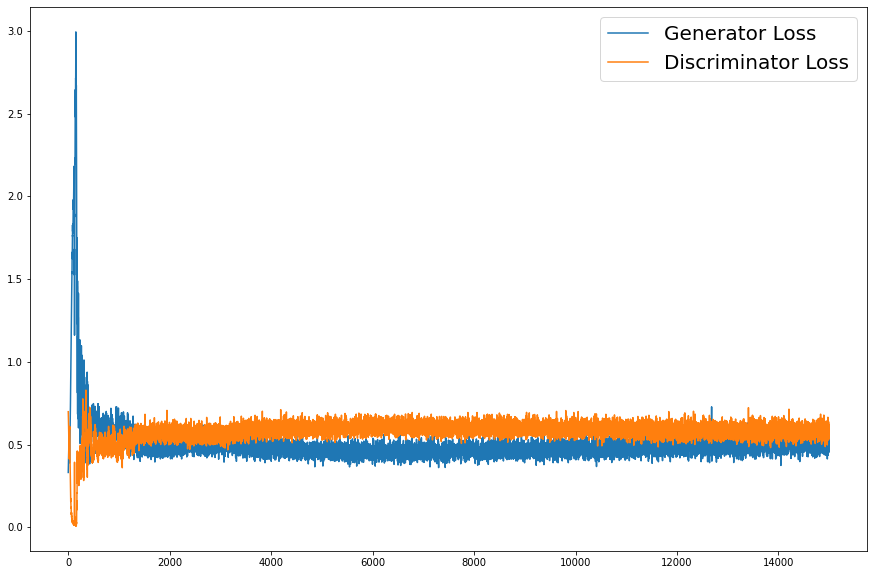

In [205]:
plt.figure(figsize=(15,10))
plt.plot(losses_gan[:])
plt.plot(losses_dis[:])
plt.legend(['Generator Loss','Discriminator Loss'],fontsize=20)
plt.show()

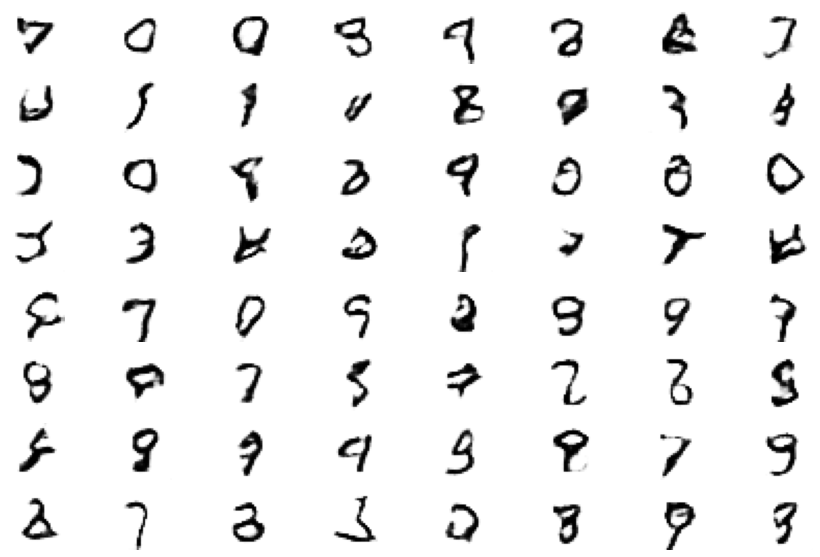

In [206]:
# display k * k generated figures 
# (these are the results after 15000 epochs, further on training does not make significant improvements)
display_row = 8
latent_seeds = np.random.randn(display_row**2, latent_dim)
latent_seeds = torch.Tensor(latent_seeds)
samples_fake = generator(latent_seeds).detach().numpy().reshape((display_row**2,28,28))
plt.figure(figsize=(15,10))
for i in range(display_row**2):
    plt.subplot(display_row,display_row,1+i)
    plt.axis('off')
    plt.imshow(samples_fake[i], cmap='gray_r')
plt.show()

In [175]:
def validate_gan(generator,discriminator,batch_size):
    latent_seeds = np.random.randn(batch_size , latent_dim)
    latent_seeds = torch.Tensor(latent_seeds)
    samples_fake = generator(latent_seeds)
    predicts_fake = discriminator(samples_fake).detach().numpy()
    acc_fake = 1. - np.sum(np.argmax(predicts_fake, axis=-1)) / batch_size


    samples_real = generate_samples(batch_size).reshape((batch_size, 1, 28, 28))
    samples_real *= 0.5
    samples_real += 0.5
    samples_real = torch.Tensor(samples_real)
    predicts_real = discriminator(samples_real)
    acc_real = np.sum(np.argmax(predicts_real.detach().numpy(), axis=-1)) / batch_size

    return acc_fake, acc_real

acc_fake, acc_real = validate_gan(generator,discriminator,500)
print(f'Accuracy on generated images = {acc_fake * 100}%')
print(f'Accuracy on realworld images = {acc_real * 100}%')

Accuracy on generated images = 72.2%
Accuracy on realworld images = 71.2%


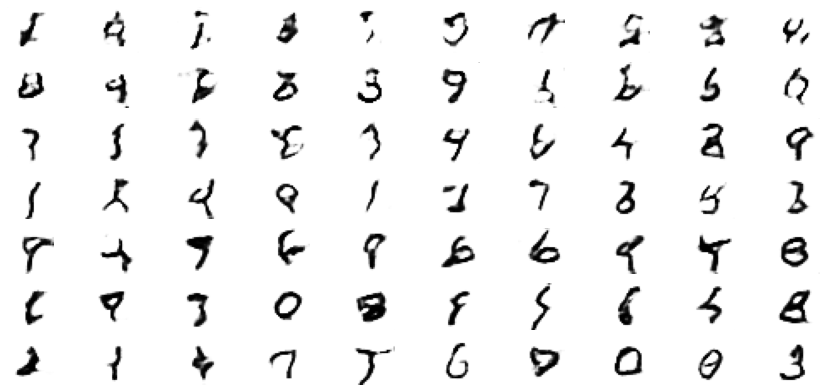

In [203]:
# check the performance of models with different training epochs
display_row = 10
display_col = 7
plt.figure(figsize=(15,10))
for i in range(display_col):
    loadepoch = 1000 + 2000 * (i+1)

    generator.load_state_dict(torch.load(f'DCGAN Models\\Generator {loadepoch}.pth'))
    discriminator.load_state_dict(torch.load(f'DCGAN Models\\Discriminator {loadepoch}.pth'))
    latent_seeds = np.random.randn(display_row, latent_dim)
    latent_seeds = torch.Tensor(latent_seeds)
    samples_fake = generator(latent_seeds).detach().numpy().reshape((display_row,28,28))

    for j in range(display_row):
        plt.subplot(display_row,display_row,i*display_row+j+1)
        plt.axis('off')
        plt.imshow(samples_fake[j], cmap='gray_r')
plt.show()